Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import files
import joblib


Upload TRAIN & VAL Data

In [ ]:
train_df = pd.read_csv(list(files.upload().keys())[0])
val_df   = pd.read_csv(list(files.upload().keys())[0])


Saving engagement_train (3).csv to engagement_train (3) (1).csv


Saving engagement_val (3).csv to engagement_val (3) (1).csv


Prepare Feature

In [ ]:
FEATURES = ["engagement_score_scaled"]

X_train = train_df[FEATURES].fillna(0).values
X_val   = val_df[FEATURES].fillna(0).values


Combine TRAIN + VAL

In [ ]:
tv = pd.concat([train_df, val_df], ignore_index=True)
X_tv = tv[FEATURES].fillna(0).values


Train K-Means (K = 3)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_tv)

joblib.dump(kmeans, "kmeans_k3.pkl")
files.download("kmeans_k3.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Assign Clusters

In [ ]:
train_df["cluster_id"] = kmeans.predict(X_train)
val_df["cluster_id"]   = kmeans.predict(X_val)
tv["cluster_id"]       = kmeans.labels_


Label Clusters

In [ ]:
# Label clusters using K-Means centroids (stable)
centers = kmeans.cluster_centers_.flatten()

order = np.argsort(centers)[::-1]  # highest centroid = Active

label_map = {
    order[0]: "Active",
    order[1]: "Moderate",
    order[2]: "Passive"
}


Evaluate Model

In [ ]:
def evaluate(X, labels):
    if len(np.unique(labels)) > 1:
        print("Silhouette:", round(silhouette_score(X, labels), 4))
        print("DB Index :", round(davies_bouldin_score(X, labels), 4))

evaluate(X_train, train_df["cluster_id"])
evaluate(X_val, val_df["cluster_id"])
evaluate(X_tv, tv["cluster_id"])


Silhouette: 0.8576
DB Index : 0.3281
Silhouette: 0.8408
DB Index : 0.3113
Silhouette: 0.8546
DB Index : 0.3252


Upload test Data

In [ ]:
print("\nUpload engagement_test.csv")
uploaded = files.upload()
test_file = list(uploaded.keys())[0]
test_df = pd.read_csv(test_file)

X_test = test_df[FEATURES].fillna(0).values


Upload engagement_test.csv


Saving engagement_test (3).csv to engagement_test (3).csv


Predict on Test

In [ ]:
test_df["cluster_id"] = kmeans.predict(X_test)
test_df["engagement_label"] = test_df["cluster_id"].map(label_map)

print(test_df[["engagement_score", "cluster_id", "engagement_label"]].head())

   engagement_score  cluster_id engagement_label
0          0.000000           1          Passive
1          0.505638           0         Moderate
2          0.525690           0         Moderate
3          0.000000           1          Passive
4          0.550633           2           Active


Evaluation on TEST

In [ ]:
def evaluate_split(name, X, labels):
    print(f"\n{name} metrics:")
    if len(np.unique(labels)) > 1:
        print("Silhouette:", round(silhouette_score(X, labels), 4))
        print("DB Index :", round(davies_bouldin_score(X, labels), 4))
    else:
        print("Only one cluster present")

evaluate_split("TEST", X_test, test_df["cluster_id"].values)

print("\nTEST label distribution:")
print(test_df["engagement_label"].value_counts())

print("\nAverage engagement_score per label (TEST):")
print(
    test_df.groupby("engagement_label")["engagement_score"]
           .mean()
           .sort_values(ascending=False)
)



TEST metrics:
Silhouette: 0.848
DB Index : 0.3107

TEST label distribution:
engagement_label
Moderate    480
Passive     243
Active       42
Name: count, dtype: int64

Average engagement_score per label (TEST):
engagement_label
Active      0.550436
Moderate    0.508339
Passive     0.000000
Name: engagement_score, dtype: float64


Save final predictions

In [ ]:
test_df.to_csv("test_with_clusters.csv", index=False)
files.download("test_with_clusters.csv")

print("\n Training, evaluation & prediction completed")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Training, evaluation & prediction completed


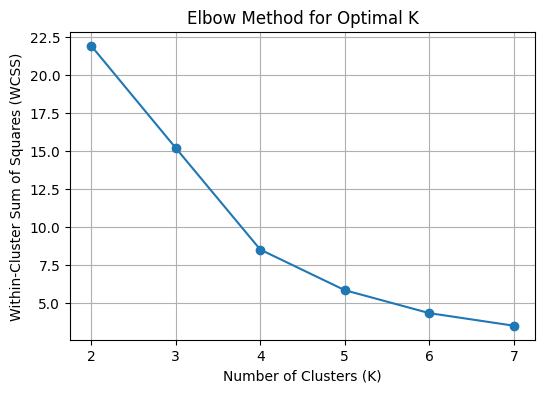

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []

K_RANGE = range(2, 8)

for k in K_RANGE:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_tmp.fit(X_tv)
    wcss.append(kmeans_tmp.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_RANGE, wcss, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


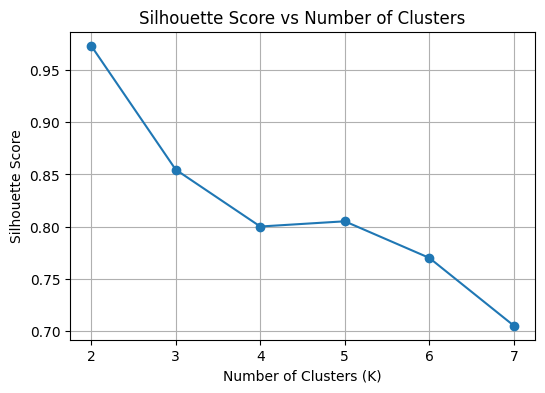

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_RANGE = range(2, 8)

for k in K_RANGE:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_tmp.fit_predict(X_tv)
    score = silhouette_score(X_tv, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(K_RANGE, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()


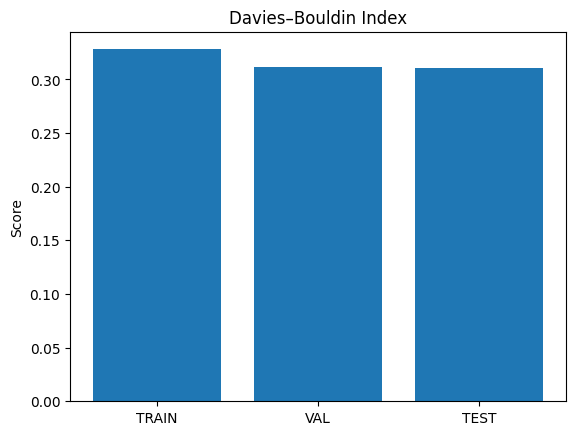

In [ ]:
plt.bar(["TRAIN", "VAL", "TEST"],
        [metrics_train["Davies-Bouldin (lower=better)"],
         metrics_val["Davies-Bouldin (lower=better)"],
         metrics_test["Davies-Bouldin (lower=better)"]])
plt.title("Davies–Bouldin Index")
plt.ylabel("Score")
plt.show()


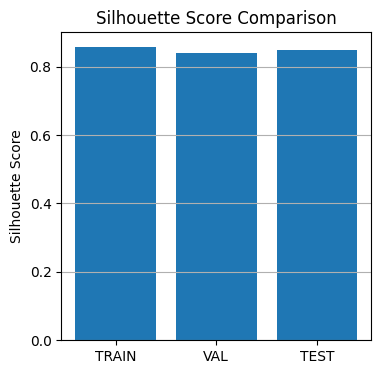

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.bar(
    ["TRAIN", "VAL", "TEST"],
    [
        metrics_train["Silhouette (higher=better)"],
        metrics_val["Silhouette (higher=better)"],
        metrics_test["Silhouette (higher=better)"]
    ]
)
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Comparison")
plt.grid(axis="y")
plt.show()


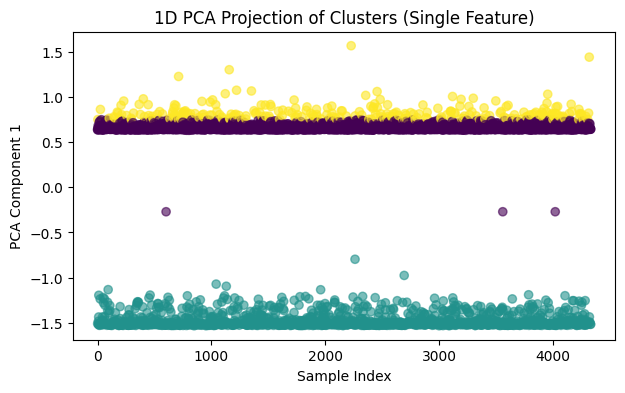

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=1)
X_1d = pca.fit_transform(X_tv).flatten()

plt.figure(figsize=(7,4))
plt.scatter(range(len(X_1d)), X_1d, c=tv["cluster_id"], alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("PCA Component 1")
plt.title("1D PCA Projection of Clusters (Single Feature)")
plt.show()
